In [12]:
import pandas as pd
import json
import matplotlib.pyplot as plt

df = pd.read_csv('fct_invoice.csv')
dim = pd.read_json('dim_customer.json')

## Easy

### 1. How many unique customers are in the dataset?

In [13]:
df["customer_id"].nunique()

5191

### 2. What are the different categories of products available? How many unique categories are there?

In [14]:
unique_cat = df["category"].unique()
num_cat = df["category"].nunique()

print(unique_cat)
print(num_cat)

['Clothing' 'Shoes' 'Books' 'Cosmetics' 'Food & Beverage' 'Toys'
 'Technology' 'Souvenir']
8


### 3. Which payment method is the most popular? How many times was it used?

In [15]:
pop_method = df["payment_method"].value_counts().idxmax()
times_used = df["payment_method"].value_counts().max()

print(pop_method)
print(times_used)


Cash
44447


## Medium

### 1. What are the three most popular categories, by total sales?

In [16]:
df["sales"] = df["quantity"] * df["price"]

top_3 = df.groupby("category")["sales"].sum().sort_values(ascending=False).head(3)

sales_by_category = df.groupby("category", as_index=False)["sales"].sum()
top_3 = sales_by_category.nlargest(3, "sales")

print("Top 3 Popular Categories:")
for idx, row in top_3.iterrows():
    print(f"{row['category']}: ₱{row['sales']:,.2f}")

Top 3 Popular Categories:
Clothing: ₱113,996,791.04
Shoes: ₱66,553,451.47
Technology: ₱57,862,350.00


### 2. What are the total sales attributed to customers over the age of 45?

In [17]:
df = pd.read_csv("fct_invoice.csv")
df_dim = pd.read_json("dim_customer.json")

df_dim = df_dim.rename(columns={"id": "customer_id"})

merged_df = pd.merge(df, df_dim[["customer_id", "age"]], on="customer_id", how="inner")

over_45_df = merged_df[merged_df["age"] > 45].copy()
over_45_df["sales"] = over_45_df["quantity"] * over_45_df["price"]
total_sales_over_45 = over_45_df["sales"].sum()

print("Total sales from customers over age 45:", total_sales_over_45)

Total sales from customers over age 45: 82039768.15


### 3. How is the data distributed across different invoice dates? Are there any seasonal trends or patterns? (Use a graph for this.)

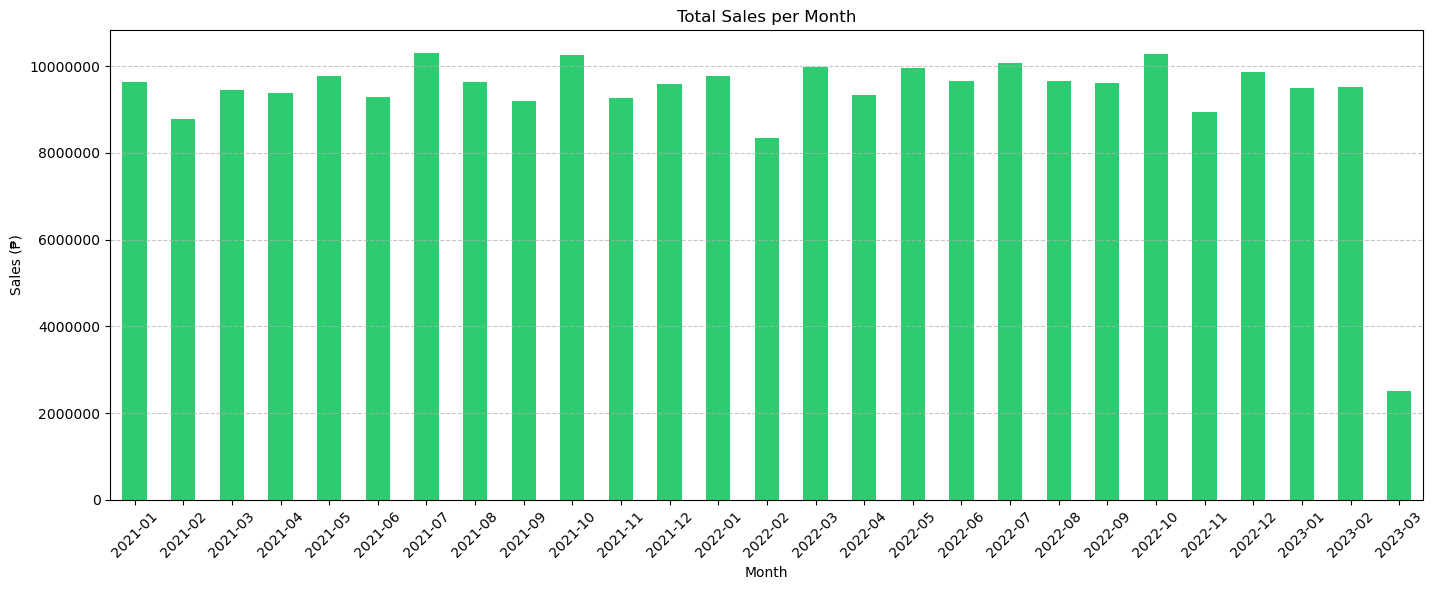

The bar graph shows that sales activity remains relatively consistent across all months. There are no significant peaks or dips, indicating a stable purchasing pattern over time.


In [18]:
df["invoice_date"] = pd.to_datetime(df["invoice_date"], dayfirst=True, errors="coerce")
df["total_sales"] = df["quantity"] * df["price"]
monthly_sales = df.groupby(df["invoice_date"].dt.to_period("M"))["total_sales"].sum().sort_index()

plt.figure(figsize=(14, 6))
monthly_sales.plot(kind="bar", color="#2ecc71")
plt.title("Total Sales per Month")
plt.xlabel("Month")
plt.ylabel("Sales (₱)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ticklabel_format(style="plain", axis="y")
plt.show()

print("The bar graph shows that sales activity remains relatively consistent across all months. There are no significant peaks or dips, indicating a stable purchasing pattern over time.")

## Hard

### 1. Create a pivot table showing the breakdown of sales across these dimensions, in this order: category, decade age range (e.g., 10-19, 20-29, and so forth).

In [19]:
merged_df["total_sales"] = merged_df["quantity"] * merged_df["price"]

merged_df["age_range"] = merged_df["age"].apply(
    lambda age: "Unknown" if pd.isna(age) else f"{int(age // 10) * 10}-{int(age // 10) * 10 + 9}"
)

age_order = sorted(
    [r for r in merged_df["age_range"].unique() if r != "Unknown"],
    key=lambda x: int(x.split("-")[0])
)
age_order.append("Unknown")

pivot = pd.pivot_table(
    merged_df,
    index="category",
    columns="age_range",
    values="total_sales",
    aggfunc="sum",
    fill_value=0
)

pivot = pivot[age_order]
pivot["Total"] = pivot.sum(axis=1)
pivot.loc["Total"] = pivot.sum()

pivot.style.format("₱{:,.2f}")

age_range,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,Unknown,Total
category,,,,,,,,,,
Books,"₱12,801.75","₱79,461.75","₱84,143.10","₱87,203.40","₱74,962.20","₱80,476.80","₱54,827.85","₱26,664.00","₱334,012.05","₱834,552.90"
Clothing,"₱1,927,413.84","₱10,250,732.80","₱11,354,126.96","₱11,215,189.92","₱10,321,851.76","₱10,660,642.08","₱7,769,371.28","₱4,493,698.00","₱46,003,764.40","₱113,996,791.04"
Cosmetics,"₱109,619.36","₱605,915.32","₱723,544.70","₱665,034.96","₱587,780.96","₱649,990.76","₱419,082.62","₱254,531.60","₱2,777,362.62","₱6,792,862.90"
Food & Beverage,"₱13,582.31","₱73,491.96","₱87,246.86","₱89,553.29","₱72,425.04","₱80,976.09","₱55,050.98","₱31,332.93","₱345,875.59","₱849,535.05"
Shoes,"₱993,281.35","₱5,924,878.24","₱7,200,839.66","₱7,025,590.02","₱5,852,857.84","₱5,978,893.54","₱4,480,269.05","₱2,628,744.60","₱26,468,097.17","₱66,553,451.47"
Souvenir,"₱12,375.15","₱54,943.32","₱64,092.72","₱66,391.80","₱54,943.32","₱55,025.43","₱38,673.81","₱23,718.06","₱265,661.04","₱635,824.65"
Technology,"₱1,129,800.00","₱5,261,550.00","₱6,159,300.00","₱5,954,550.00","₱4,435,200.00","₱5,471,550.00","₱3,638,250.00","₱1,946,700.00","₱23,865,450.00","₱57,862,350.00"
Toys,"₱60,426.24","₱385,100.80","₱420,582.40","₱390,906.88","₱345,067.52","₱363,955.20","₱273,244.16","₱153,932.80","₱1,587,210.24","₱3,980,426.24"
Total,"₱4,259,300.00","₱22,636,074.19","₱26,093,876.40","₱25,494,420.27","₱21,745,088.64","₱23,341,509.90","₱16,728,769.75","₱9,559,321.99","₱101,647,433.11","₱251,505,794.25"
